# 03 Response surfaces

One fruitful application that employs the existence of an Active Subspace is the design of response surfaces, see [Constantine, Paul G. active subspaces: emerging ideas for dimension reduction in parameter studies](https://doi.org/10.1137/1.9781611973860). In particular we will build response surfaces with Gaussian process regression. 

We will show the better results obtained by the optimal profile that theoretically establishes the optimal a priori estimate of the root mean square error on the ridge approximation, see also [Zahm, Olivier, Paul G. Constantine, Clementine Prieur, and Youssef M. Marzouk. "Gradient-based dimension reduction of multivariate vector-valued functions."](https://epubs.siam.org/doi/pdf/10.1137/18M1221837).

To have a clear view on the procedure the following are the approximations involved

$$\large
f(\mathbf{X}) \approx g_{\epsilon, \omega}(\mathbf{W}_1\mathbf{X})\approx
    \hat{g}_{\epsilon, \omega, M}(\hat{\mathbf{W}}_1\mathbf{X})\approx
    \mathscr{R}_{\epsilon,\omega,M,\delta}(\hat{\mathbf{W}}_1\mathbf{X}), 
$$

1. approximation with the exact optimal profile and exact gradients $g_{\epsilon, \omega}=\mathbb{E}_{\rho}[f|\mathbf{W}_{1}\mathbf{X}]$
2. approximation of the correlation matrix $\mathbf{C}$ with Monte Carlo and use of approximated gradients: $g_{\epsilon, M, \omega}(\hat{\mathbf{W}}_1\mathbf{X})$
3. regression with Gaussian processes: $\mathscr{R}_{\epsilon,\omega,M,\delta}(\hat{\mathbf{W}}_1\mathbf{X})$

The library we use for Gaussian process regression is [GPy](https://github.com/SheffieldML/GPy) and for Hamiltonian Monte Carlo [pyhmc](https://github.com/rmcgibbo/pyhmc).

In [3]:
import autograd.numpy as np
from autograd import elementwise_grad as egrad
import matplotlib.pyplot as plt
from functools import partial

import GPy
from pyhmc import hmc
from queue import Queue
from threading import Thread
import timeit

from athena.active import ActiveSubspaces
from athena.utils import Normalizer

from data.numpy_functions import sin_2d, radial

In [4]:
np.random.seed(42)

# Global parameters
n_samples = 50
input_dim = 5

In [5]:
# Uniformly distributed inputs
lb = 0 * np.ones(input_dim)
ub = 2 * np.ones(input_dim)

def inputs_uniform(n_samples, n_pars, lb,  ub):
    return np.vstack(
        np.array([np.random.uniform(lb[i], ub[i], n_samples) for i in range(n_pars)]).T)

In [6]:
# Gaussian model for the inputs
mean = np.ones(input_dim)
cov = 0.5*np.diag(np.ones(input_dim))

def inputs_gaussian(n_samples, mean, cov):
    return np.random.multivariate_normal(mean, cov, n_samples)

The model of interest is an hyperparaboloid. We define also the optimal profile $\mathbb{E}_{\rho}[f|W_{1}^{T}\mathbf{X}]$ that will be used instead of the model $f(W_{1}^{T}\mathbf{X})$ achieving the theoretical optimal a priori estiamte.

In [9]:
def generatrix(x):
    return x

def output(x, normalizer, r):
    return r(np.linalg.norm(normalizer.inverse_transform(x)**2, axis=1)**2)

def profile(active, ss, f_out, N=10):
    return (1/N)*np.sum(np.array([f_out(ss.backward(active)[0]) for i in range(N)]), axis=0)

In [10]:
# Generate and normalize inputs
X = inputs_uniform(n_samples, input_dim, lb, ub) #X = inputs_gaussian(M, mean, cov)
nor = Normalizer(lb, ub)
x = nor.fit_transform(X)

# Define the output of interest and compute the gradients
func = partial(output, normalizer=nor, r=generatrix)
f = func(x)
df = egrad(func)(x)

We compute the active subspace and use the method ActiveSubspaces.backward to approximate with Monte Carlo the optimal profile 

$$\mathbb{E}_{\rho}[f|W_{1}^{T}\mathbf{X}]\approx\frac{1}{N}\sum_{i=1}^{N}f(W_{1}Y+W_{2}\mathbf{Z}_{i})$$

where $\mathbf{Y}=W_{1}^{T}\mathbf{X}$ and $\mathbf{Z}=W_{2}^{T}\mathbf{X}$ are the active and inactive variables respectively. The optimal profile depends only on the variables $\mathbf{Y}$ while the inactive ones are sampled from the conditional distribution $p(\mathbf{z}|\mathbf{y})$: this is done with importance sampling inside athena, but is implemented only for the uniform distirbution. For a more general distribution we will use Hamiltonian Monte Carlo.

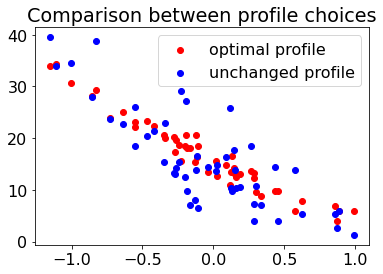

In [13]:
# Compute the active subspace
asub = ActiveSubspaces()
asub.compute(gradients=df)
asub.partition(1)

M_test = 50
X_test = inputs_uniform(M_test, input_dim, lb, ub)
nor = Normalizer(lb, ub)
x_test = nor.fit_transform(X_test)
f_test = func(x_test)
x_forward = asub.forward(x_test)[0]
g = profile(x_forward, asub, func)
plt.scatter(x_forward, g, c='r', label='optimal profile')
plt.scatter(x_forward, f_test, c='b', label='unchanged profile')
plt.legend()
plt.title('Comparison between profile choices')
plt.show()

Optimization restart 1/5, f = 96.9898027941446
Optimization restart 2/5, f = 96.9898027941581
Optimization restart 3/5, f = 96.98980279449098
Optimization restart 4/5, f = 96.9898027943552
Optimization restart 5/5, f = 96.98980279413568
Optimization restart 1/5, f = 155.8851566347876
Optimization restart 2/5, f = 155.88515663618716
Optimization restart 3/5, f = 155.88515663434478
Optimization restart 4/5, f = 155.88515663436687
Optimization restart 5/5, f = 155.8851566343088


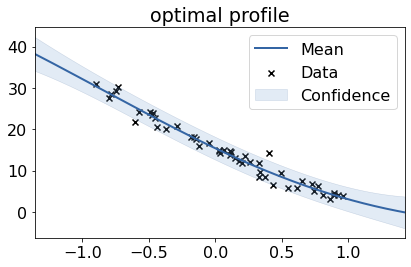

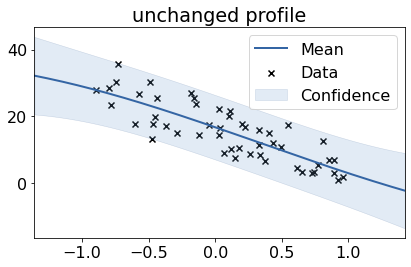

Relative Root Mean Square Error for optimal profile 9.422%
Relative Root Mean Square Error for unchanged profile 33.476%


In [12]:
gp_g = GPy.models.GPRegression(x_forward, g.reshape(-1, 1))
gp_f = GPy.models.GPRegression(x_forward, f_test.reshape(-1, 1))

gp_g.constrain_positive('')
gp_g.optimize_restarts(5)

gp_f.constrain_positive('')
gp_f.optimize_restarts(5)

y_g = gp_g.predict(x_forward)[0]
y_f = gp_f.predict(x_forward)[0]

gp_g.plot(title="optimal profile")
gp_f.plot(title="unchanged profile")

plt.show()

def RRMSE(test, true):
    return np.sqrt(np.sum((test.reshape(-1) - true.reshape(-1))**2) )#/ np.sum((true - true.mean())**2))

print("Relative Root Mean Square Error for optimal profile {:.3f}%".format(RRMSE(y_g, g)))
print("Relative Root Mean Square Error for unchanged profile {:.3f}%".format(RRMSE(y_f, f_test)))

### Remarks

Try to change the output of interest. What is the effect of choosing the optimal profile from the practical point of view of building a response surface?

# Response surfcaces with HMC

A part from the uniform distribution for which an importance sampling algorithm is efficient to sample from the conditional distribution $p(z|y)$, in the general case sampling can be achieved with more advanced methods like Hamiltonian Monte Carlo.

In the following case we consider the inputs distributed according to the probability density function

$$\large
p(y, z) \propto \exp\left(-\frac{1}{20}\left(\lVert \mathbf{W}_{1}y+\mathbf{W}_{2}z- 5c\rVert^{2}_{2}\right)-\frac{1}{20}\left(\lVert \mathbf{W}_{1}y+\mathbf{W}_{2}z- c\rVert^{2}_{2}\right)\right)
$$

where $c$ is a constant vector with the same dimension of the input space and ones as components.

In [15]:
# Global parameters
n_samples = 500
input_dim = 2

In [16]:
# logarithm of the probability density p(x)=p(y, z)
def log_proposal(x, V):
    dV = egrad(V)
    return V(x), dV(x)


# logarithm of the conditional probability density p(z|y)
def log_inactive_con_active(z, y, ss, V):
    func_z = lambda z_: V(ss.W1 * y + ss.W2 * z_)
    dfunc_z = egrad(func_z)
    return func_z(z), dfunc_z(z)

# optimal profile
def profile(active, ss, f_out, N=10):
    """
    Optimal profile of AS ridge approximation.
    :param ndarray active: active variables at which the optimal profile will be queried at
    :param ActiveSubspace ss: active subspaces of output of interest
    :param function f_out: output of interest
    :param int N: number of Monte Carlo samples
    :rtype: ndarray
    """
    y = np.array([active])
    pr_args = (y, ss, V)
    inactive = chains(log_inactive_con_active,
                      1,
                      n_samples=N,
                      epsilon=0.2,
                      pr_args=pr_args,
                      dim=1,
                      n_burn=100)
    x = np.hstack((y * np.ones((10, 1)), inactive)).dot(ss.evects.T)
    return (1 / N) * np.sum(f_out(x))

In [17]:
# Potential
V = lambda x_: -(0.5 * (1 / 10) * np.linalg.norm(x_ - 5*np.ones([input_dim]))**2
                 ) - 0.5 * (1 / 10) * np.linalg.norm(x_ - 1*np.ones([input_dim]))**2

Parallel implementation of sampling procedure with hmc.

In [18]:
def chains(proposal, N, **kwargs):
    """
    Sample from log probability density function proposal,
    with N threads.
    """
    q = Queue()
    threads = []
    thread_ind(proposal, N, q, threads, kwargs)

    for t in threads:
        t.join()

    results = []
    while True:
        if not q.empty():
            results.append(q.get())
        else:
            break
    return np.vstack(results)

def thread_ind(proposal, N, q, threads, kwargs):
    for i in range(N):
        t = Thread(target=func_thread, args=(proposal, q), kwargs=kwargs)
        t.start()
        threads.append(t)
        
def func_thread(proposal, queue, **kwargs):
    """
    Sample from log probability density function proposal with pyhmc,
    see https://github.com/rmcgibbo/pyhmc for tutorials.
    """
    res = hmc(proposal,
              args=(*kwargs['pr_args'], ),
              x0=np.random.randn(kwargs['dim']) + 1.5 * np.ones(kwargs['dim']),
              n_samples=kwargs['n_samples'],
              display=True,
              n_steps=40,
              n_burn=kwargs['n_burn'],
              epsilon=kwargs['epsilon'],
              return_diagnostics=True)
    queue.put(res[0])

Sample inputs from $p(x)\sim\exp(-V(x))$ in parallel.

In [19]:
t3 = timeit.default_timer()
X = chains(log_proposal,
           1,
           n_samples=1000,
           epsilon=0.1,
           pr_args=(V, ),
           dim=input_dim,
           n_burn=1000)
print("timer {} s".format(timeit.default_timer() - t3))

New position is
 [ 9.19704487 -1.37329895]
  Sample rejected -1000.  Threshold: 0.0672693

New position is
 [7.30696243 0.19032477]
  Sample rejected -999.  Threshold: 0.313629

New position is
 [2.65698036 3.30752708]
Finished step -998  Threshold: 1.14983

New position is
 [3.63988772 2.86499804]
Finished step -997  Threshold: 0.989387

New position is
 [-2.93948568  0.70059872]
  Sample rejected -996.  Threshold: 0.136994

New position is
 [0.29823339 2.85586687]
Finished step -995  Threshold: 0.7108

New position is
 [ 0.66269138 -0.91347229]
Finished step -994  Threshold: 0.513494

New position is
 [4.26953016 4.43723596]
Finished step -993  Threshold: 2.33249

New position is
 [-2.67093044  5.44658449]
  Sample rejected -992.  Threshold: 0.1814

New position is
 [8.05529498 2.80892523]
Finished step -991  Threshold: 0.337778

New position is
 [0.43119567 7.76920586]
Finished step -990  Threshold: 0.83044

New position is
 [3.25141229 6.97597461]
Finished step -989  Threshold: 1.9

New position is
 [ 2.63700322 -0.34321149]
Finished step -902  Threshold: 1.02234

New position is
 [ 5.89026448 10.09946596]
  Sample rejected -901.  Threshold: 0.0953822

New position is
 [2.35718563 0.20012858]
Finished step -900  Threshold: 1.16342

New position is
 [-0.58827002  1.4952717 ]
Finished step -899  Threshold: 0.710985

New position is
 [5.14473254 6.01389427]
Finished step -898  Threshold: 1.0748

New position is
 [-2.25614993  1.8128493 ]
  Sample rejected -897.  Threshold: 0.467493

New position is
 [1.2475635 7.4971848]
Finished step -896  Threshold: 0.621229

New position is
 [3.51508014 7.29424411]
Finished step -895  Threshold: 1.25523

New position is
 [3.07733581 6.49812317]
Finished step -894  Threshold: 1.37725

New position is
 [5.23998132 3.40851056]
Finished step -893  Threshold: 1.41847

New position is
 [7.79182524 5.09364584]
Finished step -892  Threshold: 0.333698

New position is
 [0.10832508 5.26164475]
Finished step -891  Threshold: 1.98741

New pos

 [1.57337918 2.86357517]
Finished step -798  Threshold: 1.76994

New position is
 [2.19518511 3.20318582]
Finished step -797  Threshold: 1.06993

New position is
 [ 2.97059992 -1.81683499]
Finished step -796  Threshold: 0.327911

New position is
 [5.7203216  4.22731134]
Finished step -795  Threshold: 2.03

New position is
 [2.24314729 2.65719659]
Finished step -794  Threshold: 1.50217

New position is
 [2.69569553 0.92939849]
Finished step -793  Threshold: 0.83299

New position is
 [0.36591515 5.2960355 ]
Finished step -792  Threshold: 0.67855

New position is
 [0.25645167 2.93484604]
Finished step -791  Threshold: 1.26077

New position is
 [4.41403395 5.5026809 ]
Finished step -790  Threshold: 0.964415

New position is
 [7.00780352 3.88071537]
Finished step -789  Threshold: 0.653968

New position is
 [4.66813188 1.17006144]
Finished step -788  Threshold: 1.69938

New position is
 [2.63943733 2.15657518]
Finished step -787  Threshold: 1.29951

New position is
 [ 5.7340503  -1.07002344]

 [11.47179003 10.51182262]
  Sample rejected -690.  Threshold: 0.00773755

New position is
 [ 2.95818652 -2.02616206]
Finished step -689  Threshold: 1.2665

New position is
 [1.67531866 5.47841989]
Finished step -688  Threshold: 2.3634

New position is
 [ 3.64943652 -0.75440325]
Finished step -687  Threshold: 0.720464

New position is
 [9.25129671 1.53286677]
  Sample rejected -686.  Threshold: 0.266328

New position is
 [8.04091251 1.0452752 ]
  Sample rejected -685.  Threshold: 0.482514

New position is
 [4.16192547 0.30548911]
Finished step -684  Threshold: 1.33983

New position is
 [ 2.05307996 -1.12591198]
Finished step -683  Threshold: 0.630619

New position is
 [3.7806442 0.4491123]
Finished step -682  Threshold: 1.70753

New position is
 [5.17008763 1.48270431]
Finished step -681  Threshold: 1.00521

New position is
 [7.68795536 7.44984496]
Finished step -680  Threshold: 0.178736

New position is
 [1.13794877 4.49286412]
Finished step -679  Threshold: 5.97151

New position is
 

New position is
 [4.24376289 3.05546678]
Finished step -584  Threshold: 1.43206

New position is
 [5.25519042 6.4602692 ]
Finished step -583  Threshold: 0.463888

New position is
 [-1.96084637  7.14801364]
  Sample rejected -582.  Threshold: 0.293436

New position is
 [7.320057   4.95949435]
Finished step -581  Threshold: 0.763702

New position is
 [3.95224178 7.90016692]
Finished step -580  Threshold: 0.887232

New position is
 [4.05824493 4.08965452]
Finished step -579  Threshold: 3.06436

New position is
 [ 7.92164132 11.0467498 ]
  Sample rejected -578.  Threshold: 0.0136751

New position is
 [10.16513951  4.22478672]
  Sample rejected -577.  Threshold: 0.0818682

New position is
 [6.27022502 0.44052275]
  Sample rejected -576.  Threshold: 0.4772

New position is
 [ 1.01488426 10.20812322]
  Sample rejected -575.  Threshold: 0.0703611

New position is
 [-1.49205413 -1.17574061]
  Sample rejected -574.  Threshold: 0.174006

New position is
 [1.86686587 0.94488509]
Finished step -573

 [3.66165762 9.92557326]
  Sample rejected -477.  Threshold: 0.0976375

New position is
 [3.59734193 3.18390555]
Finished step -476  Threshold: 1.05261

New position is
 [4.27095751 1.70467919]
Finished step -475  Threshold: 0.866103

New position is
 [ 1.73412529 -0.70671402]
  Sample rejected -474.  Threshold: 0.550606

New position is
 [ 2.21083711 -1.25000386]
Finished step -473  Threshold: 0.466588

New position is
 [3.75493648 0.5170611 ]
Finished step -472  Threshold: 1.80733

New position is
 [7.20190719 3.07695849]
  Sample rejected -471.  Threshold: 0.582067

New position is
 [4.7810289  2.90580312]
Finished step -470  Threshold: 1.19245

New position is
 [ 6.72182806 -1.66028459]
  Sample rejected -469.  Threshold: 0.201069

New position is
 [5.41443395 3.62363269]
Finished step -468  Threshold: 0.860335

New position is
 [6.7321013 4.4100682]
Finished step -467  Threshold: 0.618583

New position is
 [3.36647056 3.17675046]
Finished step -466  Threshold: 2.18169

New positio

 [ 3.02790343 -0.07369994]
Finished step -375  Threshold: 0.770457

New position is
 [9.1412625  4.30373214]
  Sample rejected -374.  Threshold: 0.226704

New position is
 [1.56425227 6.11104817]
Finished step -373  Threshold: 0.892711

New position is
 [2.62495399 6.35085866]
Finished step -372  Threshold: 1.01855

New position is
 [1.77627923 9.47203657]
  Sample rejected -371.  Threshold: 0.204823

New position is
 [2.1282772  3.57418894]
Finished step -370  Threshold: 1.66378

New position is
 [2.59683346 7.98845859]
  Sample rejected -369.  Threshold: 0.305281

New position is
 [6.23036642 2.1800009 ]
Finished step -368  Threshold: 0.608868

New position is
 [11.76879836  0.74500344]
  Sample rejected -367.  Threshold: 0.0299013

New position is
 [2.41753564 5.71077161]
Finished step -366  Threshold: 1.18458

New position is
 [4.15949297 3.33738626]
Finished step -365  Threshold: 1.3614

New position is
 [2.50320467 3.36053141]
Finished step -364  Threshold: 1.05502

New position 

 [5.10554738 1.61812275]
Finished step -266  Threshold: 1.33566

New position is
 [1.7229113  4.46365003]
Finished step -265  Threshold: 1.13572

New position is
 [-4.20743393  5.57317561]
  Sample rejected -264.  Threshold: 0.0662862

New position is
 [-2.64624285e-03  9.81428656e+00]
  Sample rejected -263.  Threshold: 0.0773547

New position is
 [-2.63213729  0.97372431]
  Sample rejected -262.  Threshold: 0.204441

New position is
 [-0.07297699  1.55542159]
  Sample rejected -261.  Threshold: 0.681022

New position is
 [ 2.79248222 -1.20733366]
  Sample rejected -260.  Threshold: 0.500599

New position is
 [5.52458234 5.20116617]
Finished step -259  Threshold: 0.691605

New position is
 [6.20245168 7.60040369]
Finished step -258  Threshold: 0.36771

New position is
 [8.58444029 6.42965259]
Finished step -257  Threshold: 0.564967

New position is
 [13.62490486  6.3850605 ]
  Sample rejected -256.  Threshold: 0.0177505

New position is
 [ 0.26521995 10.93237332]
  Sample rejected -25

 [-0.20963976  2.36623153]
  Sample rejected -158.  Threshold: 0.662316

New position is
 [-2.17672734  3.18563911]
  Sample rejected -157.  Threshold: 0.297947

New position is
 [6.18123642 0.3994    ]
  Sample rejected -156.  Threshold: 0.487688

New position is
 [3.76005518 4.64381721]
Finished step -155  Threshold: 0.956619

New position is
 [1.30914481 5.14852533]
Finished step -154  Threshold: 0.812388

New position is
 [0.49312714 8.98439206]
Finished step -153  Threshold: 0.180019

New position is
 [0.93840773 0.60433026]
Finished step -152  Threshold: 4.9046

New position is
 [-4.49381799 -2.93773222]
  Sample rejected -151.  Threshold: 0.0177278

New position is
 [-0.21447098  0.25493567]
  Sample rejected -150.  Threshold: 0.676918

New position is
 [2.56527869 3.41796336]
Finished step -149  Threshold: 1.61079

New position is
 [2.65201067 1.00525633]
Finished step -148  Threshold: 0.831063

New position is
 [3.0118748  2.12204533]
Finished step -147  Threshold: 1.17925

Ne

 [1.76716066 2.10884457]
Finished step  -54  Threshold: 0.996206

New position is
 [4.14456736 3.54488105]
Finished step  -53  Threshold: 1.03564

New position is
 [4.7134506 2.5298621]
Finished step  -52  Threshold: 0.926107

New position is
 [ 7.69599117 -0.23432512]
  Sample rejected  -51.  Threshold: 0.233659

New position is
 [9.06671882 1.69769771]
Finished step  -50  Threshold: 0.173696

New position is
 [-0.65371162  3.46549594]
Finished step  -49  Threshold: 3.43809

New position is
 [0.79986444 1.71804461]
Finished step  -48  Threshold: 1.42014

New position is
 [ 3.10314017 -2.46283288]
  Sample rejected  -47.  Threshold: 0.314309

New position is
 [5.24074155 1.34313586]
Finished step  -46  Threshold: 0.938476

New position is
 [ 7.00023597 -0.15486642]
  Sample rejected  -45.  Threshold: 0.406235

New position is
 [-0.66446138  7.12970646]
  Sample rejected  -44.  Threshold: 0.324633

New position is
 [1.76894515 2.87727021]
Finished step  -43  Threshold: 1.36182

New posi

 [4.27547774 2.90379846]
Finished step   51  Threshold: 2.97046

New position is
 [-3.91283445  3.6764064 ]
  Sample rejected   52.  Threshold: 0.0994266

New position is
 [ 5.79278645 -0.91793617]
  Sample rejected   53.  Threshold: 0.34456

New position is
 [2.10305792 5.35337659]
Finished step   54  Threshold: 0.792068

New position is
 [ 0.23226959 -1.15341101]
  Sample rejected   55.  Threshold: 0.398675

New position is
 [ 3.94251324 -1.67712513]
  Sample rejected   56.  Threshold: 0.44341

New position is
 [3.58081781 6.41243604]
  Sample rejected   57.  Threshold: 0.756324

New position is
 [7.95745934 1.66993924]
  Sample rejected   58.  Threshold: 0.371337

New position is
 [ 2.49061251 -0.57574679]
Finished step   59  Threshold: 0.717523

New position is
 [-0.39378449  1.33569581]
Finished step   60  Threshold: 0.940331

New position is
 [ 4.36984007 -0.91688472]
  Sample rejected   61.  Threshold: 0.864894

New position is
 [-1.47399024 -1.95847974]
  Sample rejected   62. 

 [1.3724478  3.49939164]
Finished step  160  Threshold: 0.935677

New position is
 [-1.87476171  6.74206182]
  Sample rejected  161.  Threshold: 0.177841

New position is
 [-2.51713935  4.59528396]
  Sample rejected  162.  Threshold: 0.225371

New position is
 [0.45612208 1.31025534]
Finished step  163  Threshold: 0.727338

New position is
 [ 3.44496874 -4.87192498]
  Sample rejected  164.  Threshold: 0.0730305

New position is
 [2.35771754 0.4228868 ]
Finished step  165  Threshold: 1.11913

New position is
 [-0.20193788 -5.5995645 ]
  Sample rejected  166.  Threshold: 0.0219067

New position is
 [-1.93702213  0.48399772]
  Sample rejected  167.  Threshold: 0.309962

New position is
 [4.47270784 4.02108548]
Finished step  168  Threshold: 1.20962

New position is
 [ 3.92851011 -2.84959378]
  Sample rejected  169.  Threshold: 0.206324

New position is
 [ 3.5673485  -4.06668494]
  Sample rejected  170.  Threshold: 0.0972847

New position is
 [3.74014442 2.94895556]
Finished step  171  Thr

 [3.02869115 2.25200291]
Finished step  266  Threshold: 2.06881

New position is
 [0.01475282 4.16628175]
Finished step  267  Threshold: 0.618181

New position is
 [7.32991715 2.41450579]
Finished step  268  Threshold: 0.646119

New position is
 [3.67792134 0.87737062]
Finished step  269  Threshold: 2.01294

New position is
 [-2.64528733  7.55536019]
  Sample rejected  270.  Threshold: 0.0944036

New position is
 [ 2.74979629 -0.50685419]
Finished step  271  Threshold: 0.693317

New position is
 [-0.59631922  0.01046735]
Finished step  272  Threshold: 0.624378

New position is
 [4.67708271 0.6217914 ]
Finished step  273  Threshold: 1.94208

New position is
 [0.75752431 0.9371307 ]
Finished step  274  Threshold: 0.96041

New position is
 [-0.37175653  6.39651573]
  Sample rejected  275.  Threshold: 0.509366

New position is
 [2.48430179 4.029153  ]
Finished step  276  Threshold: 1.48316

New position is
 [-0.02667271  7.2943773 ]
  Sample rejected  277.  Threshold: 0.272149

New positio

 [1.59089619 3.98747879]
  Sample rejected  375.  Threshold: 0.872108

New position is
 [4.98396996 6.81269088]
Finished step  376  Threshold: 0.404505

New position is
 [3.92933354 1.39869419]
Finished step  377  Threshold: 2.10668

New position is
 [5.39267137 4.93695764]
Finished step  378  Threshold: 0.741134

New position is
 [-5.17771079  2.22464699]
  Sample rejected  379.  Threshold: 0.056559

New position is
 [7.00607129 4.58233875]
  Sample rejected  380.  Threshold: 0.637958

New position is
 [5.29367596 3.8993278 ]
Finished step  381  Threshold: 1.1838

New position is
 [2.23366871 4.60642128]
Finished step  382  Threshold: 1.15456

New position is
 [-0.20503235  4.49407735]
  Sample rejected  383.  Threshold: 0.629767

New position is
 [2.17151399 0.53662061]
Finished step  384  Threshold: 0.837245

New position is
 [ 3.09968628 -2.17018921]
  Sample rejected  385.  Threshold: 0.371639

New position is
 [3.33224087 5.38156293]
Finished step  386  Threshold: 1.04934

New po

 [5.70896568 5.62628197]
  Sample rejected  485.  Threshold: 0.578108

New position is
 [ 1.5124572  -0.71945419]
Finished step  486  Threshold: 0.528507

New position is
 [0.35505077 1.59179268]
Finished step  487  Threshold: 1.41916

New position is
 [ 5.98971951 -0.85608684]
Finished step  488  Threshold: 0.479784

New position is
 [7.85938442 9.08320196]
  Sample rejected  489.  Threshold: 0.161524

New position is
 [6.12265197 0.79954144]
Finished step  490  Threshold: 1.57834

New position is
 [ 2.76417079 -0.21105101]
Finished step  491  Threshold: 1.23284

New position is
 [-2.97356924  6.21585757]
  Sample rejected  492.  Threshold: 0.17101

New position is
 [ 2.61317943 -1.45308947]
  Sample rejected  493.  Threshold: 0.621201

New position is
 [4.32764391 0.70189568]
Finished step  494  Threshold: 1.17886

New position is
 [7.96633605 0.39584157]
  Sample rejected  495.  Threshold: 0.298633

New position is
 [ 2.69860175 -3.57236106]
  Sample rejected  496.  Threshold: 0.166

New position is
 [5.87614114 8.09237737]
Finished step  590  Threshold: 0.878606

New position is
 [7.1180042  7.20275067]
Finished step  591  Threshold: 0.97958

New position is
 [3.54664528 4.66249353]
Finished step  592  Threshold: 4.7729

New position is
 [ 2.15051071 -3.85321385]
  Sample rejected  593.  Threshold: 0.109688

New position is
 [0.40477205 0.82102746]
  Sample rejected  594.  Threshold: 0.659002

New position is
 [3.64235064 5.37134299]
  Sample rejected  595.  Threshold: 0.863079

New position is
 [0.22611444 3.06710527]
  Sample rejected  596.  Threshold: 0.794841

New position is
 [ 6.83943537 -1.09575443]
  Sample rejected  597.  Threshold: 0.24434

New position is
 [3.67607039 0.42995242]
Finished step  598  Threshold: 0.820305

New position is
 [4.82232964 3.13612241]
Finished step  599  Threshold: 1.20247

New position is
 [-0.75614639  1.06347491]
  Sample rejected  600.  Threshold: 0.487199

New position is
 [ 1.61129802 -2.28784866]
  Sample rejected  601. 

 [8.63562693 3.71318401]
Finished step  696  Threshold: 0.261724

New position is
 [4.84604434 2.86868841]
Finished step  697  Threshold: 4.17249

New position is
 [0.9171606  7.93756045]
Finished step  698  Threshold: 0.28575

New position is
 [-2.17121766e-03  3.78986904e+00]
Finished step  699  Threshold: 2.57279

New position is
 [-1.61806561  0.14353629]
  Sample rejected  700.  Threshold: 0.374173

New position is
 [1.53276338 1.0843073 ]
Finished step  701  Threshold: 1.20793

New position is
 [2.46665365 5.73382436]
Finished step  702  Threshold: 0.90859

New position is
 [1.75005809 2.6083922 ]
Finished step  703  Threshold: 1.34886

New position is
 [4.85538344 6.53084025]
  Sample rejected  704.  Threshold: 0.495123

New position is
 [-0.73455363  0.44802369]
  Sample rejected  705.  Threshold: 0.395225

New position is
 [0.6986945  0.15132232]
Finished step  706  Threshold: 0.560337

New position is
 [ 5.10759182 -0.25189015]
Finished step  707  Threshold: 0.923553

New pos

 [7.01182782 2.77700135]
  Sample rejected  800.  Threshold: 0.490028

New position is
 [-0.0578256   1.76058164]
  Sample rejected  801.  Threshold: 0.635791

New position is
 [ 6.28314215 -0.08863038]
  Sample rejected  802.  Threshold: 0.39851

New position is
 [3.74919085 4.27119023]
Finished step  803  Threshold: 0.978678

New position is
 [-1.01366994  5.70621942]
Finished step  804  Threshold: 0.348988

New position is
 [-2.24212515  5.4365286 ]
Finished step  805  Threshold: 0.609915

New position is
 [0.41244316 2.6689606 ]
Finished step  806  Threshold: 3.73578

New position is
 [1.4958411  3.25612388]
Finished step  807  Threshold: 1.24823

New position is
 [0.33671035 3.03316473]
Finished step  808  Threshold: 0.789744

New position is
 [7.76960206 5.80986204]
  Sample rejected  809.  Threshold: 0.311504

New position is
 [3.97417441 4.11068324]
Finished step  810  Threshold: 1.27539

New position is
 [-0.08703412  3.04902489]
Finished step  811  Threshold: 0.694896

New po

 [-0.68371072  8.546845  ]
  Sample rejected  909.  Threshold: 0.121445

New position is
 [4.86972173 2.41741838]
Finished step  910  Threshold: 0.902671

New position is
 [1.92882786 1.68931454]
Finished step  911  Threshold: 1.04921

New position is
 [3.47398777 2.04135384]
Finished step  912  Threshold: 1.08901

New position is
 [-0.09848452  3.9625515 ]
  Sample rejected  913.  Threshold: 0.628309

New position is
 [6.22767727 0.53934308]
Finished step  914  Threshold: 0.468048

New position is
 [2.08871416 4.57789614]
Finished step  915  Threshold: 1.91821

New position is
 [-1.30896756  3.69749987]
Finished step  916  Threshold: 0.458766

New position is
 [0.2713484  2.58772103]
Finished step  917  Threshold: 1.76206

New position is
 [-3.12256944  2.04268028]
  Sample rejected  918.  Threshold: 0.217677

New position is
 [2.96549051 0.74670382]
Finished step  919  Threshold: 1.13388

New position is
 [3.96121723 3.82443316]
Finished step  920  Threshold: 1.18779

New position is

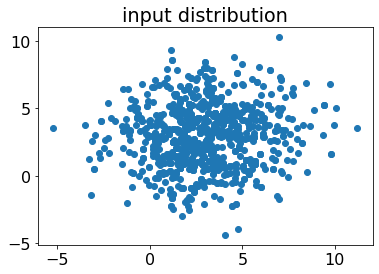

In [20]:
plt.scatter(X[:, 0], X[:, 1])
plt.title("input distribution")
plt.show()

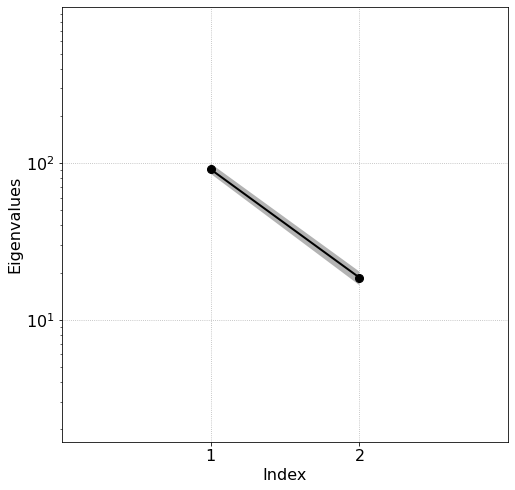

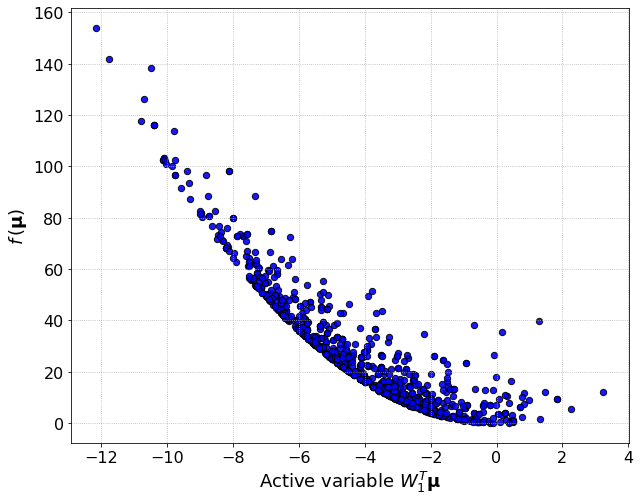

In [21]:
# Define the output of interest and compute the gradients
func = partial(radial, normalizer=None, generatrix=lambda x: x)
f = func(X)
df = egrad(func)(X)

# Compute the active subspace
asub = ActiveSubspaces()
asub.compute(gradients=df)
asub.partition(1)
asub.plot_eigenvalues()
asub.plot_sufficient_summary(X, f)

Use again parallel implementation of hmc sampling to compute the outputs of the optimal profile $g$ at the active components of the inputs X_test.

New position is
 [4.22686097 8.90602116]
Finished step -300  Threshold: 0.177152

New position is
 [ 2.01466298 -0.16217832]
Finished step -299  Threshold: 4.00663

New position is
 [3.99333508 4.06587578]
Finished step -298  Threshold: 1.62118

New position is
 [3.7432412  4.34046607]
Finished step -297  Threshold: 0.98771

New position is
New position is
 [1.43489886 3.17857711]
Finished step -296  Threshold: 0.992808
 [6.67699195 4.52105399]
  Sample rejected -300.  Threshold: 0.678871

New position is

New position is
  [2.82910707 5.83746176]
Finished step -295  Threshold: 0.736567
[5.80416918 6.48405206]
Finished step -299  Threshold: 0.540672


New position is
 New position is
 [1.54924111 2.23679521][1.64938127 1.57629801]
Finished step -294  Threshold: 1.25981


New position is
 [3.80902323 2.98080498]
Finished step -293  Threshold: 1.1907

New position is
Finished step -298  Threshold: 2.57423

 [1.23961799 3.79737943]
Finished step -292  Threshold: 0.845194

New position is


New position is
Finished step -242  Threshold: 1.24623

New position is
 [2.70629742 5.14576369]
Finished step -241  Threshold: 2.49481

New position is
  [6.18189287 2.32384997]
Finished step -240  Threshold: 0.724911

New position is
 [0.14066321 3.42821342]
Finished step -239  Threshold: 1.12904

New position is
 [5.07239838 2.81747565]
Finished step -238  Threshold: 1.24624

New position is
[-0.45103643  0.39393467]
  Sample rejected -241.  Threshold: 0.58683

 [1.37438038 3.60946873]New position is
 [ 1.10567105 -0.06530763]
Finished step -240  Threshold: 0.801846


Finished step -237  Threshold: 1.0744

New position is
 [6.1223282  4.82835157]
Finished step -239  Threshold: 0.994162

New position is
 [0.42607223 3.41711008]
  Sample rejected -236.  Threshold: 0.813267

New position is
 [1.15679476 1.45754789]
Finished step -238  Threshold: 1.49105

New position is
 [7.60768457 2.33420948]
Finished step -235  Threshold: 0.360953

New position is
New position is
 [7.34084517 6.9463

 New position is
 [2.72936072 5.25860603]
Finished step -193  Threshold: 1.03731

New position is
[1.96418069 2.48571237]
Finished step -184  Threshold: 1.00684

 [ 5.15613141 -0.13260985]
  Sample rejected -192.  Threshold: 0.602186

New position is
 [4.90368875 2.34285661]
Finished step -191  Threshold: 1.06299

New position is
New position is
 [0.9415872 5.1510079]
Finished step -190  Threshold: 0.769078
 [3.46758997 4.27295288]
Finished step -183  Threshold: 0.972978

New position is

New position is
  [4.8974912  1.64381108]
Finished step -182  Threshold: 0.821494

New position is
[3.38712002 0.2823426 ]
 [2.14035638 4.20993108]
Finished step -181  Threshold: 1.19334
Finished step -189  Threshold: 1.07524


New position is
 New position is
[2.36493072 1.9177553 ] [5.17398753 1.54483133]
Finished step -180  Threshold: 0.776133

Finished step -188  Threshold: 1.38476


New position is
 [3.66655818 3.17599808]
Finished step -179  Threshold: 1.41592
New position is
 [5.03290421 5.2265

New position is
 [4.38589444 1.68284101]
Finished step -136  Threshold: 1.36709
Finished step -141  Threshold: 1.19933

New position is

 [1.58357527 0.24284163]New position is

Finished step -140  Threshold: 0.72248
 [1.69612459 1.51793996]
Finished step -135  Threshold: 0.815919

New position is

 [6.01539766 5.29179186]
  Sample rejected -134.  Threshold: 0.565199

New position is
New position is
 [3.33560215 5.46673625]
Finished step -133  Threshold: 0.881927

 New position is
 [-1.77941598  2.56111103]
  Sample rejected -132.  Threshold: 0.398713

New position is
[6.84444693 5.8214837 ]
   Sample rejected -139.  Threshold: 0.488142
[ 5.42756004 -0.0363702 ]
Finished step -131  Threshold: 0.614558

New position is
 [-1.63161035  4.33366985]
Finished step -130  Threshold: 0.641906


New position is
New position is
 [4.73329519 1.18571041]
Finished step -129  Threshold: 2.52132

New position is
 [2.6038436  3.99182308]
Finished step -128  Threshold: 1.32515

New position is
  [3.3601

New position is
  [2.18353244 3.34502872]
Finished step  -82  Threshold: 1.15666

New position is
[4.2412993 3.8294082] [3.80611413 3.50702398]
Finished step  -81  Threshold: 0.993402


Finished step  -76  Threshold: 1.00712

New position is
New position is
 [0.62747856 0.8155337 ]
Finished step  -80  Threshold: 0.595441
 [6.14599818 1.30361406]
  Sample rejected  -75.  Threshold: 0.562184


New position is
New position is
 [2.96113415 2.31404696]
Finished step  -79  Threshold: 1.71979
 
[2.81714476 3.82785606]New position is

Finished step  -74  Threshold: 1.08595
 [3.25744103 4.42455098]
Finished step  -78  Threshold: 0.915154

New position is

New position is
 [4.93544198 1.70730498] [3.75515301 2.64813372]
Finished step  -73  Threshold: 1.00135

New position is

Finished step  -77  Threshold: 0.83412

 [3.4110398  6.66029901]
  Sample rejected  -72.  Threshold: 0.495114

New position is
 [0.25645612 2.64876065]
Finished step  -76  Threshold: 0.88518
New position is

 [2.04077877 3.

 [2.86750298 3.15173448]
Finished step  -34  Threshold: 1.08498

New position is
New position is
 [1.83970457 5.2321524 ]
  Sample rejected  -33.  Threshold: 0.709358

 [0.38497125 2.23439501]
Finished step  -14  Threshold: 1.84291
New position is

 [2.46838015 2.64965449]
Finished step  -32  Threshold: 0.980277

New position is
 New position is
 [ 6.07210365 -0.74507247]
  Sample rejected  -31.  Threshold: 0.283886

New position is
[8.44132752 5.46146588]
 [3.61527697 4.6988433 ]
Finished step  -30  Threshold: 0.855437

New position is
   Sample rejected  -13.  Threshold: 0.21389
[0.70104378 0.84308672]
  Sample rejected  -29.  Threshold: 0.694614

New position is

New position is
  [6.50692356 3.18792832]
  Sample rejected  -12.  Threshold: 0.764836
[-1.529859  1.665007]
  Sample rejected  -28.  Threshold: 0.353593

New position is

New position is
  [4.96288849 0.23618495]
Finished step  -11  Threshold: 0.800835
[ 1.65762664 -2.54234537]
  Sample rejected  -27.  Threshold: 0.202383


 [0.77685963]
Finished step  -90  Threshold: 1.02639

New position is
 [-0.0460412]
Finished step  -89  Threshold: 1.04294

New position is
 [-0.91677123]
Finished step  -88  Threshold: 0.927385

New position is
 [1.21184993]
Finished step  -87  Threshold: 0.967191

New position is
 [-2.35665851]
  Sample rejected  -86.  Threshold: 0.696458

New position is
 [-1.32456857]
Finished step  -85  Threshold: 0.956639

New position is
 [1.97992265]
Finished step  -84  Threshold: 0.861948

New position is
 [-1.31220761]
Finished step  -83  Threshold: 1.16336

New position is
 [0.24170202]
Finished step  -82  Threshold: 1.15967

New position is
 [1.52388311]
Finished step  -81  Threshold: 0.840838

New position is
 [-1.66907886]
Finished step  -80  Threshold: 0.937787

New position is
 [1.32108556]
Finished step  -79  Threshold: 1.11566

New position is
 [0.53996177]
Finished step  -78  Threshold: 1.11815

New position is
 [-1.08488478]
Finished step  -77  Threshold: 0.918069

New position is
 

 [-0.66009063]
Finished step  -68  Threshold: 0.975569

New position is
 [1.11965242]
Finished step  -67  Threshold: 0.949626

New position is
 [0.24561202]
Finished step  -66  Threshold: 1.09388

New position is
 [0.67168176]
Finished step  -65  Threshold: 0.972168

New position is
 [-1.78721007]
Finished step  -64  Threshold: 0.783949

New position is
 [1.31006235]
Finished step  -63  Threshold: 1.15706

New position is
 [-1.03540642]
Finished step  -62  Threshold: 1.03341

New position is
 [0.56384934]
Finished step  -61  Threshold: 1.07745

New position is
 [-0.45370252]
Finished step  -60  Threshold: 1.00065

New position is
 [1.25155676]
Finished step  -59  Threshold: 0.908086

New position is
 [-1.25025226]
Finished step  -58  Threshold: 0.979673

New position is
 [0.42889236]
Finished step  -57  Threshold: 1.13436

New position is
 [0.2976858]
Finished step  -56  Threshold: 1.00668

New position is
 [-1.10975877]
Finished step  -55  Threshold: 0.900677

New position is
 [2.5370

 [-1.9670759]
  Sample rejected  -58.  Threshold: 0.768614

New position is
 [-0.72895797]
Finished step  -57  Threshold: 1.01864

New position is
 [1.80251057]
  Sample rejected  -56.  Threshold: 0.818843

New position is
 [0.01585895]
Finished step  -55  Threshold: 1.05061

New position is
 [-0.17845319]
Finished step  -54  Threshold: 0.995825

New position is
 [0.00543318]
Finished step  -53  Threshold: 1.00412

New position is
 [0.05188739]
Finished step  -52  Threshold: 1.00017

New position is
 [-0.40060909]
Finished step  -51  Threshold: 0.983548

New position is
 [0.03529266]
Finished step  -50  Threshold: 1.01671

New position is
 [-1.37120733]
  Sample rejected  -49.  Threshold: 0.848378

New position is
 [1.10205961]
Finished step  -48  Threshold: 0.914155

New position is
 [-1.78130256]
Finished step  -47  Threshold: 0.832623

New position is
 [1.36872321]
Finished step  -46  Threshold: 1.14092

New position is
 [-1.73699268]
Finished step  -45  Threshold: 0.887991

New pos

 [-0.95014693]
Finished step  -39  Threshold: 1.17443

New position is
 [1.65467882]
Finished step  -38  Threshold: 0.880277

New position is
 [-1.41308585]
Finished step  -37  Threshold: 1.03535

New position is
 [1.61321019]
Finished step  -36  Threshold: 0.976219

New position is
 [-2.14187749]
Finished step  -35  Threshold: 0.824819

New position is
 [2.1222862]
Finished step  -34  Threshold: 1.04315

New position is
 [-1.9505154]
Finished step  -33  Threshold: 1.02327

New position is
 [1.29772197]
Finished step  -32  Threshold: 1.22063

New position is
 [-0.61977924]
Finished step  -31  Threshold: 1.09387

New position is
 [0.48459441]
Finished step  -30  Threshold: 1.02155

New position is
 [-0.15213522]
Finished step  -29  Threshold: 1.01198

New position is
 [-0.11913222]
Finished step  -28  Threshold: 1.001

New position is
 [-0.41147798]
Finished step  -27  Threshold: 0.985072

New position is
 [1.73313824]
Finished step  -26  Threshold: 0.808502

New position is
 [-1.808913

New position is
 [1.34888928]
Finished step  -26  Threshold: 0.968849

New position is
 [-1.54602022]
Finished step  -25  Threshold: 0.931967

New position is
 [2.50068309]
Finished step  -24  Threshold: 0.755493

New position is
 [-2.82153359]
  Sample rejected  -23.  Threshold: 0.832718

New position is
 [-1.03618387]
Finished step  -22  Threshold: 1.4794

New position is
 [1.29303353]
Finished step  -21  Threshold: 0.97116

New position is
 [-0.98436455]
Finished step  -20  Threshold: 1.03895

New position is
 [0.73406559]
Finished step  -19  Threshold: 1.05048

New position is
 [-1.1549032]
Finished step  -18  Threshold: 0.922817

New position is
 [1.99126633]
Finished step  -17  Threshold: 0.828834

New position is
 [-0.8287666]
Finished step  -16  Threshold: 1.27511

New position is
 [0.95252416]
Finished step  -15  Threshold: 0.996896

New position is
 [-0.80987132]
Finished step  -14  Threshold: 1.0058

New position is
 [0.51601815]
Finished step  -13  Threshold: 1.04362

New p

 [2.05842204]
  Sample rejected   -9.  Threshold: 0.733396

New position is
 [0.10307717]
Finished step   -8  Threshold: 1.01738

New position is
 [-1.40910619]
  Sample rejected   -7.  Threshold: 0.841044

New position is
 [0.54041079]
Finished step   -6  Threshold: 0.980944

New position is
 [0.59325838]
Finished step   -5  Threshold: 0.995579

New position is
 [-1.68227124]
Finished step   -4  Threshold: 0.802234

New position is
 [1.46716171]
Finished step   -3  Threshold: 1.08465

New position is
 [-1.33635968]
Finished step   -2  Threshold: 1.00652

New position is
 [2.51515087]
  Sample rejected   -1.  Threshold: 0.713888

New position is
 [1.24536537]
Finished step    0  Threshold: 1.0414

New position is
 [-2.05189947]
Finished step    1  Threshold: 0.783812

New position is
 [2.74067523]
Finished step    2  Threshold: 0.795741

New position is
 [-1.71453834]
Finished step    3  Threshold: 1.39734

New position is
 [-0.21666999]
Finished step    4  Threshold: 1.28094

New posi

 [1.51654117]
Finished step   -1  Threshold: 0.882672

New position is
 [-0.21769485]
Finished step    0  Threshold: 1.18374

New position is
 [1.08913217]
Finished step    1  Threshold: 0.921543

New position is
 [-1.0016956]
Finished step    2  Threshold: 0.99748

New position is
 [1.8341512]
Finished step    3  Threshold: 0.845086

New position is
 [-2.26258854]
Finished step    4  Threshold: 0.838

New position is
 [1.81039961]
Finished step    5  Threshold: 1.20151

New position is
 [-1.68588587]
Finished step    6  Threshold: 1.00634

New position is
 [-0.53445571]
Finished step    7  Threshold: 1.24283

New position is
 [-0.25027097]
Finished step    8  Threshold: 1.0207

New position is
 [0.84290689]
Finished step    9  Threshold: 0.957363


Fraction of samples rejected:  0

New position is
 [-1.93782424]
Finished step -100  Threshold: 0.748325

New position is
 [1.6691618]
Finished step  -99  Threshold: 1.1149

New position is
 [-0.53147236]
Finished step  -98  Threshold: 1.20

New position is
 [-0.3291874]
Finished step -100  Threshold: 1.01296

New position is
 [0.85038278]
Finished step  -99  Threshold: 0.960629

New position is
 [-0.87962486]
Finished step  -98  Threshold: 0.981674

New position is
 [1.51270194]
Finished step  -97  Threshold: 0.901928

New position is
 [-0.45369988]
Finished step  -96  Threshold: 1.16524

New position is
 [0.95924857]
Finished step  -95  Threshold: 0.95474

New position is
 [-0.20617236]
Finished step  -94  Threshold: 1.06359

New position is
 [1.10144182]
Finished step  -93  Threshold: 0.919167

New position is
 [-0.37982333]
Finished step  -92  Threshold: 1.07742

New position is
 [0.23189878]
Finished step  -91  Threshold: 1.01252

New position is
 [-0.68601232]
Finished step  -90  Threshold: 0.959335

New position is
 [-0.70554893]
Finished step  -89  Threshold: 0.99763

New position is
 [1.32485968]
Finished step  -88  Threshold: 0.918207

New position is
 [-0.79683903]
Finished step  -87  Threshold: 1.07619

New pos

New position is
 [-0.61205787]
Finished step  -89  Threshold: 1.02855

New position is
 [0.51150638]
Finished step  -88  Threshold: 1.0187

New position is
 [-0.24530551]
Finished step  -87  Threshold: 1.01013

New position is
 [-1.01375203]
Finished step  -86  Threshold: 0.918479

New position is
 [2.40904566]
Finished step  -85  Threshold: 0.697849

New position is
 [-3.41643084]
Finished step  -84  Threshold: 0.591279

New position is
 [3.61245304]
Finished step  -83  Threshold: 0.947852

New position is
 [-1.46430302]
Finished step  -82  Threshold: 2.32629

New position is
 [2.02332101]
Finished step  -81  Threshold: 0.87855

New position is
 [-1.36433821]
Finished step  -80  Threshold: 1.16567

New position is
 [0.52696276]
Finished step  -79  Threshold: 1.15542

New position is
 [-1.32335549]
Finished step  -78  Threshold: 0.87357

New position is
 [0.86050239]
Finished step  -77  Threshold: 1.10553

New position is
 [-0.30679261]
Finished step  -76  Threshold: 1.04376

New posit

New position is
 [-1.12394394]
Finished step  -70  Threshold: 1.02817

New position is
 [0.216049]
Finished step  -69  Threshold: 1.11631

New position is
 [-0.85951188]
Finished step  -68  Threshold: 0.93688

New position is
 [0.88411207]
Finished step  -67  Threshold: 1.01107

New position is
 [0.96099076]
Finished step  -66  Threshold: 0.989168

New position is
 [-0.66316507]
Finished step  -65  Threshold: 1.02615

New position is
 [-0.40298533]
Finished step  -64  Threshold: 1.02502

New position is
 [1.78642486]
Finished step  -63  Threshold: 0.796118

New position is
 [-1.65432113]
Finished step  -62  Threshold: 1.00837

New position is
 [1.78857746]
Finished step  -61  Threshold: 0.991092

New position is
 [-1.71375601]
Finished step  -60  Threshold: 0.992212

New position is
 [1.66308487]
Finished step  -59  Threshold: 1.04288

New position is
 [-1.82662887]
Finished step  -58  Threshold: 0.927366

New position is
 [1.70343557]
Finished step  -57  Threshold: 1.06684

New positi

 [1.33948727]
Finished step  -49  Threshold: 0.94979

New position is
 [-1.78879168]
Finished step  -48  Threshold: 0.86913

New position is
 [3.1244349]
  Sample rejected  -47.  Threshold: 0.611048

New position is
 [3.13134576]
Finished step  -46  Threshold: 0.608939

New position is
 [-2.65342376]
Finished step  -45  Threshold: 1.19319

New position is
 [2.27163134]
Finished step  -44  Threshold: 1.21385

New position is
 [-0.87744365]
Finished step  -43  Threshold: 1.39194

New position is
 [0.89122904]
Finished step  -42  Threshold: 1.0128

New position is
 [-1.18621425]
Finished step  -41  Threshold: 0.935114

New position is
 [2.98865857]
Finished step  -40  Threshold: 0.561597

New position is
 [-2.95980733]
  Sample rejected  -39.  Threshold: 0.965115

New position is
 [-3.36101756]
  Sample rejected  -38.  Threshold: 0.782716

New position is
 [-3.38124941]
Finished step  -37  Threshold: 0.773955

New position is
 [3.0748543]
Finished step  -36  Threshold: 1.23921

New positi

 [1.41791338]
Finished step  -39  Threshold: 0.870779

New position is
 [-1.01231928]
Finished step  -38  Threshold: 1.06175

New position is
 [2.83735021]
Finished step  -37  Threshold: 0.583276

New position is
 [-3.75599052]
  Sample rejected  -36.  Threshold: 0.578586

New position is
 [-0.51270736]
Finished step  -35  Threshold: 1.83159

New position is
 [0.20038408]
Finished step  -34  Threshold: 1.02432

New position is
 [-1.34367021]
Finished step  -33  Threshold: 0.855274

New position is
 [1.15886806]
Finished step  -32  Threshold: 1.06014

New position is
 [-0.78738628]
Finished step  -31  Threshold: 1.04351

New position is
 [0.48099022]
Finished step  -30  Threshold: 1.04304

New position is
 [-0.17318003]
Finished step  -29  Threshold: 1.01099

New position is
 [-1.36960406]
  Sample rejected  -28.  Threshold: 0.852153

New position is
 [0.70993329]
Finished step  -27  Threshold: 0.969293

New position is
 [-2.50493129]
  Sample rejected  -26.  Threshold: 0.609077

New po

New position is
 [-0.71577973]
Finished step  -13  Threshold: 1.04097

New position is
 [3.55689279]
  Sample rejected  -12.  Threshold: 0.386266

New position is
 [1.93098059]
Finished step  -11  Threshold: 0.787068

New position is
 [-2.92973524]
Finished step  -10  Threshold: 0.647242

New position is
 [1.47883696]
Finished step   -9  Threshold: 1.74473

New position is
 [-0.67680757]
Finished step   -8  Threshold: 1.13045

New position is
 [2.54374705]
  Sample rejected   -7.  Threshold: 0.630043

New position is
 [-1.10952817]
Finished step   -6  Threshold: 0.935727

New position is
 [1.31074987]
Finished step   -5  Threshold: 0.980724

New position is
 [-0.33087263]
Finished step   -4  Threshold: 1.12424

New position is
 [1.24055311]
Finished step   -3  Threshold: 0.902006

New position is
 [0.18801258]
Finished step   -2  Threshold: 1.12016

New position is
 [1.04636194]
Finished step   -1  Threshold: 0.92405

New position is
 [-1.38934445]
  Sample rejected    0.  Threshold: 0

 [0.49598957]
Finished step    9  Threshold: 1.19409


Fraction of samples rejected:  0

New position is
 [-2.47464732]
Finished step -100  Threshold: 0.844267

New position is
 [0.89509797]
Finished step  -99  Threshold: 1.58515

New position is
 [-2.78540152]
  Sample rejected  -98.  Threshold: 0.550936

New position is
 [-0.38434726]
Finished step  -97  Threshold: 1.0434

New position is
 [1.35094081]
Finished step  -96  Threshold: 0.885223

New position is
 [-1.24074759]
Finished step  -95  Threshold: 1.00167

New position is
 [2.14749485]
  Sample rejected  -94.  Threshold: 0.801264

New position is
 [-0.41258499]
Finished step  -93  Threshold: 1.12545

New position is
 [-0.9168244]
Finished step  -92  Threshold: 0.943006

New position is
 [-0.47000914]
Finished step  -91  Threshold: 1.05557

New position is
 [0.25869838]
Finished step  -90  Threshold: 1.01875

New position is
 [-0.27659086]
Finished step  -89  Threshold: 0.994784

New position is
 [-1.09547892]
Finished step  -88

 [0.26910117]
Finished step  -90  Threshold: 1.17025

New position is
 [0.38741293]
Finished step  -89  Threshold: 0.994684

New position is
 [0.25210121]
Finished step  -88  Threshold: 1.00593

New position is
 [-0.95415685]
Finished step  -87  Threshold: 0.924162

New position is
 [0.35731939]
Finished step  -86  Threshold: 1.07738

New position is
 [0.01297256]
Finished step  -85  Threshold: 1.00753

New position is
 [-0.90726205]
Finished step  -84  Threshold: 0.928164

New position is
 [-0.51516136]
Finished step  -83  Threshold: 1.0498

New position is
 [2.50574291]
Finished step  -82  Threshold: 0.628958

New position is
 [-1.64682946]
Finished step  -81  Threshold: 1.29098

New position is
 [1.11172191]
Finished step  -80  Threshold: 1.15364

New position is
 [-1.70649078]
Finished step  -79  Threshold: 0.852413

New position is
 [2.18270963]
Finished step  -78  Threshold: 0.888504

New position is
 [-2.31308936]
Finished step  -77  Threshold: 0.918487

New position is
 [1.7318

 [0.4014955]
Finished step  -73  Threshold: 0.994712

New position is
 [-0.11722981]
Finished step  -72  Threshold: 1.0077

New position is
 [-0.18628461]
Finished step  -71  Threshold: 0.997725

New position is
 [0.73444247]
Finished step  -70  Threshold: 0.96718

New position is
 [-0.20260832]
Finished step  -69  Threshold: 1.03326

New position is
 [0.7138023]
Finished step  -68  Threshold: 0.969999

New position is
 [-1.53389442]
Finished step  -67  Threshold: 0.844909

New position is
 [0.76956133]
Finished step  -66  Threshold: 1.17617

New position is
 [-0.06452564]
Finished step  -65  Threshold: 1.04171

New position is
 [2.34211421]
  Sample rejected  -64.  Threshold: 0.65341

New position is
 [1.51268179]
Finished step  -63  Threshold: 0.841517

New position is
 [-1.64168826]
Finished step  -62  Threshold: 0.942419

New position is
 [2.76144324]
Finished step  -61  Threshold: 0.694773

New position is
 [-3.42022993]
  Sample rejected  -60.  Threshold: 0.682201

New position i

 [-0.12661475]
Finished step  -54  Threshold: 1.03245

New position is
 [1.69563417]
Finished step  -53  Threshold: 0.804721

New position is
 [-1.54138852]
Finished step  -52  Threshold: 1.01377

New position is
 [2.56914135]
Finished step  -51  Threshold: 0.734013

New position is
 [-3.58321203]
  Sample rejected  -50.  Threshold: 0.572183

New position is
 [-1.16391363]
Finished step  -49  Threshold: 1.48494

New position is
 [1.49387196]
Finished step  -48  Threshold: 0.952003

New position is
 [-0.73064235]
Finished step  -47  Threshold: 1.12695

New position is
 [1.18794577]
Finished step  -46  Threshold: 0.946138

New position is
 [-0.95063823]
Finished step  -45  Threshold: 1.02375

New position is
 [2.22550875]
Finished step  -44  Threshold: 0.738793

New position is
 [-1.79553877]
Finished step  -43  Threshold: 1.11305

New position is
 [0.85319957]
Finished step  -42  Threshold: 1.25222

New position is
 [-0.90581402]
Finished step  -41  Threshold: 0.978095

New position is


 [0.35084015]
Finished step  -45  Threshold: 1.03495

New position is
 [0.54260847]
Finished step  -44  Threshold: 0.987743

New position is
 [-1.13680991]
Finished step  -43  Threshold: 0.9093

New position is
 [0.65894635]
Finished step  -42  Threshold: 1.08837

New position is
 [-1.56146802]
Finished step  -41  Threshold: 0.834136

New position is
 [2.13686777]
  Sample rejected  -40.  Threshold: 0.867421

New position is
 [1.66001024]
Finished step  -39  Threshold: 1.00098

New position is
 [-2.09104266]
Finished step  -38  Threshold: 0.849919

New position is
 [1.9035592]
Finished step  -37  Threshold: 1.09866

New position is
 [-1.94357669]
Finished step  -36  Threshold: 0.956474

New position is
 [3.92362254]
Finished step  -35  Threshold: 0.408381

New position is
 [-3.00022091]
Finished step  -34  Threshold: 1.58747

New position is
 [2.04443758]
Finished step  -33  Threshold: 1.54323

New position is
 [-3.36470002]
Finished step  -32  Threshold: 0.535003

New position is
 [2.

New position is
 [1.74338346]
Finished step  -23  Threshold: 1.05973

New position is
 [-2.15145116]
  Sample rejected  -22.  Threshold: 0.850801

New position is
 [-0.69094634]
Finished step  -21  Threshold: 1.20685

New position is
 [-0.12936178]
Finished step  -20  Threshold: 1.04302

New position is
 [-0.38289105]
Finished step  -19  Threshold: 0.987415

New position is
 [0.57518205]
Finished step  -18  Threshold: 0.993015

New position is
 [-0.5766909]
Finished step  -17  Threshold: 0.990329

New position is
 [1.7136917]
Finished step  -16  Threshold: 0.824778

New position is
 [-1.32891397]
Finished step  -15  Threshold: 1.07237

New position is
 [0.36658329]
Finished step  -14  Threshold: 1.15804

New position is
 [-0.6861736]
Finished step  -13  Threshold: 0.964542

New position is
 [0.85726023]
Finished step  -12  Threshold: 0.991405

New position is
 [-0.22866501]
Finished step  -11  Threshold: 1.04755

New position is
 [-0.48298554]
Finished step  -10  Threshold: 0.983314

N

 [-3.1337927]
Finished step  -13  Threshold: 0.612465

New position is
 [3.00094487]
Finished step  -12  Threshold: 1.12441

New position is
 [-2.55313544]
Finished step  -11  Threshold: 1.16882

New position is
 [3.44166776]
Finished step  -10  Threshold: 0.681719

New position is
 [-1.61361197]
Finished step   -9  Threshold: 2.0323

New position is
 [1.76718475]
Finished step   -8  Threshold: 0.986004

New position is
 [-3.58403549]
  Sample rejected   -7.  Threshold: 0.433964

New position is
 [-1.86137634]
Finished step   -6  Threshold: 0.943695

New position is
 [1.53539166]
Finished step   -5  Threshold: 1.12553

New position is
 [-1.55427448]
Finished step   -4  Threshold: 0.970027

New position is
 [1.74486515]
Finished step   -3  Threshold: 0.976597

New position is
 [-2.37493689]
Finished step   -2  Threshold: 0.782504

New position is
 [2.30413017]
Finished step   -1  Threshold: 1.06805

New position is
 [-1.85963978]
Finished step    0  Threshold: 1.1228

New position is
 [

 [-0.34095256]
Finished step    0  Threshold: 1.28787

New position is
 [3.55243496]
Finished step    1  Threshold: 0.373812

New position is
 [-3.03029511]
Finished step    2  Threshold: 1.2519

New position is
 [1.7296093]
Finished step    3  Threshold: 1.72088

New position is
 [-3.40274875]
  Sample rejected    4.  Threshold: 0.476782

New position is
 [-1.53656593]
Finished step    5  Threshold: 1.02439

New position is
 [1.76388364]
Finished step    6  Threshold: 0.967012

New position is
 [-1.72217923]
Finished step    7  Threshold: 0.98298

New position is
 [1.35427629]
Finished step    8  Threshold: 1.12477

New position is
 [0.25441527]
Finished step    9  Threshold: 1.14417


Fraction of samples rejected:  0.1

New position is
 [-2.81340134]
Finished step -100  Threshold: 1.05148

New position is
 [3.25683014]
  Sample rejected  -99.  Threshold: 0.845074

New position is
 [1.85884155]
Finished step  -98  Threshold: 1.49389

New position is
 [0.01357046]
Finished step  -97  T

 [0.42986182]
Finished step    5  Threshold: 0.993058

New position is
 [-2.19271241]
Finished step    6  Threshold: 0.671923

New position is
 [3.15111051]
  Sample rejected    7.  Threshold: 0.689436

New position is
 [1.96493441]
Finished step    8  Threshold: 1.11801

New position is
 [-2.14292684]
Finished step    9  Threshold: 0.910657


Fraction of samples rejected:  0.1

New position is
 [-2.04490898]
Finished step -100  Threshold: 1.2943

New position is
 [1.77149659]
Finished step  -99  Threshold: 1.12361

New position is
 [-0.51227917]
Finished step  -98  Threshold: 1.23958

New position is
 [0.7692592]
Finished step  -97  Threshold: 0.984014

New position is
 [-0.36054235]
Finished step  -96  Threshold: 1.02854

New position is
 [0.31695888]
Finished step  -95  Threshold: 1.00807

New position is
 [0.06375626]
Finished step  -94  Threshold: 1.00575

New position is
 [1.25588209]
Finished step  -93  Threshold: 0.888726

New position is
 [-1.11993933]
Finished step  -92  Thre

 [-0.67145595]
Finished step  -99  Threshold: 0.960075

New position is
 [2.65009432]
Finished step  -98  Threshold: 0.602533

New position is
 [-1.45790459]
Finished step  -97  Threshold: 1.439

New position is
 [1.84284342]
Finished step  -96  Threshold: 0.926966

New position is
 [-2.45950835]
Finished step  -95  Threshold: 0.777684

New position is
 [1.64979083]
Finished step  -94  Threshold: 1.35613

New position is
 [-2.17773146]
Finished step  -93  Threshold: 0.821946

New position is
 [1.63768995]
Finished step  -92  Threshold: 1.22044

New position is
 [-0.48500843]
Finished step  -91  Threshold: 1.19871

New position is
 [-0.47224813]
Finished step  -90  Threshold: 1.0011

New position is
 [0.93775281]
Finished step  -89  Threshold: 0.959224

New position is
 [-1.06702446]
Finished step  -88  Threshold: 0.962968

New position is
 [1.38249758]
Finished step  -87  Threshold: 0.95844

New position is
 [-0.88712638]
Finished step  -86  Threshold: 1.07522

New position is
 [1.4261

 [-0.24370077]
Finished step  -86  Threshold: 1.01983

New position is
 [0.29250066]
Finished step  -85  Threshold: 1.00233

New position is
 [-0.61107702]
Finished step  -84  Threshold: 0.969561

New position is
 [-0.83488736]
Finished step  -83  Threshold: 0.972226

New position is
 [0.80156324]
Finished step  -82  Threshold: 1.0182

New position is
 [-0.45335661]
Finished step  -81  Threshold: 1.0254

New position is
 [-0.4789488]
Finished step  -80  Threshold: 0.99785

New position is
 [0.43160934]
Finished step  -79  Threshold: 1.01114

New position is
 [-0.90935964]
Finished step  -78  Threshold: 0.938731

New position is
 [1.13100457]
Finished step  -77  Threshold: 0.980398

New position is
 [-2.82285926]
Finished step  -76  Threshold: 0.561787

New position is
 [0.80439518]
Finished step  -75  Threshold: 1.86881

New position is
 [-0.58000859]
Finished step  -74  Threshold: 1.01384

New position is
 [-0.35218876]
Finished step  -73  Threshold: 1.01934

New position is
 [0.53897

 [0.39456867]
Finished step  -72  Threshold: 1.00245

New position is
 [-0.61594261]
Finished step  -71  Threshold: 0.973764

New position is
 [-1.75907556]
Finished step  -70  Threshold: 0.794378

New position is
 [2.07041459]
Finished step  -69  Threshold: 0.936996

New position is
 [-0.64928912]
Finished step  -68  Threshold: 1.33852

New position is
 [0.41764397]
Finished step  -67  Threshold: 1.02938

New position is
 [-1.9791188]
Finished step  -66  Threshold: 0.723147

New position is
 [1.76718895]
Finished step  -65  Threshold: 1.10041

New position is
 [-1.91833382]
Finished step  -64  Threshold: 0.926887

New position is
 [0.79290762]
Finished step  -63  Threshold: 1.31072

New position is
 [0.10497957]
Finished step  -62  Threshold: 1.04549

New position is
 [0.9003561]
Finished step  -61  Threshold: 0.943286

New position is
 [-3.00959063]
Finished step  -60  Threshold: 0.495156

New position is
 [1.9169821]
Finished step  -59  Threshold: 1.61368

New position is
 [-2.50878

 [-2.15984861]
Finished step  -53  Threshold: 0.68909

New position is
 [2.05688171]
Finished step  -52  Threshold: 1.07289

New position is
 [0.04088015]
Finished step  -51  Threshold: 1.38681

New position is
 [0.70865509]
Finished step  -50  Threshold: 0.965476

New position is
 [-0.34060666]
Finished step  -49  Threshold: 1.02293

New position is
 [-0.7345153]
Finished step  -48  Threshold: 0.963002

New position is
 [0.4139407]
Finished step  -47  Threshold: 1.04027

New position is
 [-0.8049234]
Finished step  -46  Threshold: 0.952303

New position is
 [0.78628033]
Finished step  -45  Threshold: 1.01576

New position is
 [-1.08903094]
Finished step  -44  Threshold: 0.940124

New position is
 [2.04703134]
Finished step  -43  Threshold: 0.804013

New position is
 [-3.47255566]
Finished step  -42  Threshold: 0.503847

New position is
 [3.04424074]
Finished step  -41  Threshold: 1.32455

New position is
 [-1.35047758]
Finished step  -40  Threshold: 1.76567

New position is
 [2.300219

New position is
 [0.94876359]
Finished step  -30  Threshold: 0.987

New position is
 [-1.38349614]
Finished step  -29  Threshold: 0.903202

New position is
 [3.57264921]
  Sample rejected  -28.  Threshold: 0.431393

New position is
 [0.91963956]
Finished step  -27  Threshold: 1.11181

New position is
 [0.73704913]
Finished step  -26  Threshold: 1.02334

New position is
 [-1.23660696]
Finished step  -25  Threshold: 0.90796

New position is
 [1.354665]
Finished step  -24  Threshold: 0.996683

New position is
 [1.03458234]
Finished step  -23  Threshold: 1.06131

New position is
 [0.75574205]
Finished step  -22  Threshold: 1.039

New position is
 [-0.13345898]
Finished step  -21  Threshold: 1.0383

New position is
 [0.4707627]
Finished step  -20  Threshold: 0.988523

New position is
 [-0.76434319]
Finished step  -19  Threshold: 0.961035

New position is
 [2.15975757]
Finished step  -18  Threshold: 0.735382

New position is
 [-0.33990019]
Finished step  -17  Threshold: 1.41764

New position

 [1.14740918]
Finished step  -16  Threshold: 0.973775

New position is
 [-1.79052523]
Finished step  -15  Threshold: 0.836931

New position is
 [1.42336031]
Finished step  -14  Threshold: 1.13048

New position is
 [-1.42551636]
Finished step  -13  Threshold: 0.976104

New position is
 [0.78890322]
Finished step  -12  Threshold: 1.14225

New position is
 [0.04799532]
Finished step  -11  Threshold: 1.04524

New position is
 [-0.87996657]
Finished step  -10  Threshold: 0.931954

New position is
 [-0.21228775]
Finished step   -9  Threshold: 1.06698

New position is
 [1.09058528]
  Sample rejected   -8.  Threshold: 0.921102

New position is
 [0.37651392]
Finished step   -7  Threshold: 0.99704

New position is
 [-0.18586602]
Finished step   -6  Threshold: 1.00405

New position is
 [0.02533736]
Finished step   -5  Threshold: 1.00452

New position is
 [1.72579961]
Finished step   -4  Threshold: 0.796193

New position is
 [-1.73584151]
Finished step   -3  Threshold: 0.968887

New position is
 [

New position is
 [-1.80566607]
Finished step   -3  Threshold: 0.782896

New position is
 [0.75638943]
Finished step   -2  Threshold: 1.27103

New position is
 [-0.17566636]
Finished step   -1  Threshold: 1.03691

New position is
 [-0.78373863]
Finished step    0  Threshold: 0.948876

New position is
 [1.30748964]
Finished step    1  Threshold: 0.930862

New position is
 [-0.06175929]
Finished step    2  Threshold: 1.13572

New position is
 [0.22820416]
Finished step    3  Threshold: 0.998489

New position is
 [0.54234297]
Finished step    4  Threshold: 0.98308

New position is
 [-0.17120372]
Finished step    5  Threshold: 1.01572

New position is
 [0.57014044]
Finished step    6  Threshold: 0.982282

New position is
 [-2.20000863]
Finished step    7  Threshold: 0.677029

New position is
 [1.79730139]
Finished step    8  Threshold: 1.17832

New position is
 [-2.64710753]
Finished step    9  Threshold: 0.708954


Fraction of samples rejected:  0

New position is
 [-0.95788156]
Finished s

 [1.2873069]
Finished step    2  Threshold: 1.02867

New position is
 [-0.43780934]
Finished step    3  Threshold: 1.11047

New position is
 [-0.89626603]
Finished step    4  Threshold: 0.947879

New position is
 [0.82526056]
Finished step    5  Threshold: 1.02455

New position is
 [-2.29953759]
Finished step    6  Threshold: 0.670015

New position is
 [2.03981771]
Finished step    7  Threshold: 1.1362

New position is
 [-1.23161671]
Finished step    8  Threshold: 1.2065

New position is
 [0.60933946]
Finished step    9  Threshold: 1.11452


Fraction of samples rejected:  0

New position is
 [-0.81289698]
Finished step -100  Threshold: 1.09384

New position is
 [1.53959214]
Finished step  -99  Threshold: 0.887449

New position is
 [-1.23307964]
Finished step  -98  Threshold: 1.0471

New position is
 [1.67592288]
Finished step  -97  Threshold: 0.922628

New position is
 [-2.47206922]
Finished step  -96  Threshold: 0.73865

New position is
 [2.41397043]
Finished step  -95  Threshold: 1.0

New position is
 [-0.22720856]
Finished step  -97  Threshold: 1.06327

New position is
 [0.82948558]
Finished step  -96  Threshold: 0.957962

New position is
 [-1.31647069]
Finished step  -95  Threshold: 0.902315

New position is
 [2.44708021]
Finished step  -94  Threshold: 0.730086

New position is
 [-2.36811878]
Finished step  -93  Threshold: 0.990912

New position is
 [2.71151515]
Finished step  -92  Threshold: 0.905239

New position is
 [-1.24524181]
Finished step  -91  Threshold: 1.55069

New position is
 [1.13356406]
Finished step  -90  Threshold: 1.04224

New position is
 [-0.82975133]
Finished step  -89  Threshold: 1.03268

New position is
 [1.03874375]
Finished step  -88  Threshold: 0.983924

New position is
 [0.10177901]
Finished step  -87  Threshold: 1.08229

New position is
 [0.41565499]
Finished step  -86  Threshold: 0.989464

New position is
 [0.42525432]
Finished step  -85  Threshold: 0.999424

New position is
 [1.4022091]
Finished step  -84  Threshold: 0.871968

New pos

 [0.76503653]
Finished step  -89  Threshold: 1.27978

New position is
 [0.3920092]
Finished step  -88  Threshold: 1.0325

New position is
 [0.15574414]
Finished step  -87  Threshold: 1.00859

New position is
 [0.27558263]
Finished step  -86  Threshold: 0.9968

New position is
 [0.43236689]
Finished step  -85  Threshold: 0.992311

New position is
 [-1.92299255]
Finished step  -84  Threshold: 0.737139

New position is
 [2.54401871]
Finished step  -83  Threshold: 0.828317

New position is
 [-2.07938738]
Finished step  -82  Threshold: 1.14589

New position is
 [0.43768094]
Finished step  -81  Threshold: 1.42879

New position is
 [0.07714255]
Finished step  -80  Threshold: 1.01216

New position is
 [-0.22495947]
Finished step  -79  Threshold: 0.993877

New position is
 [-0.81840662]
Finished step  -78  Threshold: 0.946234

New position is
 [-1.55584395]
Finished step  -77  Threshold: 0.86204

New position is
 [2.60771631]
  Sample rejected  -76.  Threshold: 0.725147

New position is
 [2.455

 [-0.84983288]
Finished step  -71  Threshold: 1.12673

New position is
 [-0.38468462]
Finished step  -70  Threshold: 1.05184

New position is
 [1.17947267]
Finished step  -69  Threshold: 0.915716

New position is
 [-1.16086993]
Finished step  -68  Threshold: 0.984206

New position is
 [1.31263656]
Finished step  -67  Threshold: 0.9901

New position is
 [-0.75907788]
Finished step  -66  Threshold: 1.07896

New position is
 [1.15847072]
  Sample rejected  -65.  Threshold: 0.954745

New position is
 [0.80699619]
Finished step  -64  Threshold: 1.00695

New position is
 [0.05141034]
Finished step  -63  Threshold: 1.04754

New position is
 [-0.63859661]
Finished step  -62  Threshold: 0.962067

New position is
 [1.50684494]
  Sample rejected  -61.  Threshold: 0.874956

New position is
 [-1.10559037]
Finished step  -60  Threshold: 0.932307

New position is
 [1.87990368]
Finished step  -59  Threshold: 0.849516

New position is
 [-2.07999227]
Finished step  -58  Threshold: 0.907256

New position

 [1.01219986]
Finished step  -50  Threshold: 1.03596

New position is
 [-1.22603567]
Finished step  -49  Threshold: 0.944108

New position is
 [0.88919043]
Finished step  -48  Threshold: 1.07843

New position is
 [2.00295048]
Finished step  -47  Threshold: 0.776796

New position is
 [-2.6650075]
Finished step  -46  Threshold: 0.748245

New position is
 [2.63358078]
Finished step  -45  Threshold: 1.05928

New position is
 [-0.98104324]
Finished step  -44  Threshold: 1.57696

New position is
 [0.88045125]
Finished step  -43  Threshold: 1.03117

New position is
 [-0.23091717]
Finished step  -42  Threshold: 1.05068

New position is
 [0.45787732]
Finished step  -41  Threshold: 0.993044

New position is
 [-1.0248087]
Finished step  -40  Threshold: 0.922511

New position is
 [1.00821071]
Finished step  -39  Threshold: 1.01984

New position is
 [-2.20448008]
  Sample rejected  -38.  Threshold: 0.712399

New position is
 [-2.10314302]
  Sample rejected  -37.  Threshold: 0.738753

New position i

 [-1.9693369]
Finished step  -36  Threshold: 0.912343

New position is
 [0.61289602]
Finished step  -35  Threshold: 1.35824

New position is
 [0.6539934]
Finished step  -34  Threshold: 0.996117

New position is
 [-1.61319462]
Finished step  -33  Threshold: 0.822321

New position is
 [2.63551584]
Finished step  -32  Threshold: 0.727786

New position is
 [-2.68737871]
Finished step  -31  Threshold: 0.935478

New position is
 [4.74020958]
Finished step  -30  Threshold: 0.307995

New position is
 [-2.48852311]
Finished step  -29  Threshold: 3.53598

New position is
 [0.6211273]
Finished step  -28  Threshold: 1.64524

New position is
 [-1.40645206]
Finished step  -27  Threshold: 0.863905

New position is
 [0.5596609]
Finished step  -26  Threshold: 1.16379

New position is
 [-0.66043027]
Finished step  -25  Threshold: 0.980063

New position is
 [0.27871103]
Finished step  -24  Threshold: 1.03764

New position is
 [0.93036356]
Finished step  -23  Threshold: 0.943058

New position is
 [-0.3133

 [-1.56908351]
Finished step  -14  Threshold: 0.841876

New position is
 [1.91049691]
Finished step  -13  Threshold: 0.934601

New position is
 [-3.12564648]
Finished step  -12  Threshold: 0.583144

New position is
 [2.58643467]
Finished step  -11  Threshold: 1.34697

New position is
 [-2.12529314]
Finished step  -10  Threshold: 1.14734

New position is
 [2.58713149]
Finished step   -9  Threshold: 0.871334

New position is
 [-2.99843469]
Finished step   -8  Threshold: 0.792006

New position is
 [3.37001303]
Finished step   -7  Threshold: 0.869875

New position is
 [-3.49503413]
Finished step   -6  Threshold: 0.880869

New position is
 [4.55844736]
Finished step   -5  Threshold: 0.533021

New position is
 [-4.84808223]
  Sample rejected   -4.  Threshold: 0.74106

New position is
 [-1.87575898]
Finished step   -3  Threshold: 3.85586

New position is
 [1.9574733]
Finished step   -2  Threshold: 1.00643

New position is
 [-2.8875825]
Finished step   -1  Threshold: 0.665912

New position is


 [-0.4662526]
Finished step   -7  Threshold: 1.06259

New position is
 [0.56351607]
Finished step   -6  Threshold: 1.00042

New position is
 [0.00351214]
Finished step   -5  Threshold: 1.02138

New position is
 [0.38259138]
Finished step   -4  Threshold: 0.991293

New position is
 [0.28644985]
Finished step   -3  Threshold: 1.00444

New position is
 [0.1021759]
Finished step   -2  Threshold: 1.0043

New position is
 [-0.06364119]
Finished step   -1  Threshold: 0.999141

New position is
 [0.08379393]
Finished step    0  Threshold: 1.00098

New position is
 [0.53412099]
Finished step    1  Threshold: 0.981302

New position is
 [0.20179432]
Finished step    2  Threshold: 1.01726

New position is
 [0.97076589]
Finished step    3  Threshold: 0.935289

New position is
 [-0.27438532]
Finished step    4  Threshold: 1.06198

New position is
 [0.77838388]
Finished step    5  Threshold: 0.966207

New position is
 [-0.5302098]
Finished step    6  Threshold: 1.01564

New position is
 [0.18412938]
F

 [1.97763831]
Finished step   -1  Threshold: 0.800863

New position is
 [-1.02129371]
Finished step    0  Threshold: 1.23146

New position is
 [1.5034074]
Finished step    1  Threshold: 0.92501

New position is
 [-3.52435562]
Finished step    2  Threshold: 0.419896

New position is
 [0.64587933]
Finished step    3  Threshold: 2.7468

New position is
 [-1.30942982]
Finished step    4  Threshold: 0.885394

New position is
 [1.45188621]
Finished step    5  Threshold: 0.991024

New position is
 [-1.84707967]
Finished step    6  Threshold: 0.87511

New position is
 [2.23917451]
Finished step    7  Threshold: 0.908225

New position is
 [-2.31620062]
Finished step    8  Threshold: 0.935759

New position is
 [2.03517499]
Finished step    9  Threshold: 1.1452


Fraction of samples rejected:  0

New position is
 [-2.41025848]
  Sample rejected -100.  Threshold: 0.895546

New position is
 [-3.4034674]
  Sample rejected  -99.  Threshold: 0.555464

New position is
 [-0.94876464]
Finished step  -98 

 [2.1805787]
Finished step  -94  Threshold: 1.20285

New position is
 [-1.96355225]
Finished step  -93  Threshold: 1.03941

New position is
 [2.67532709]
Finished step  -92  Threshold: 0.794672

New position is
 [-3.16394199]
Finished step  -91  Threshold: 0.755425

New position is
 [1.01544966]
Finished step  -90  Threshold: 2.14826

New position is
 [0.13733849]
Finished step  -89  Threshold: 1.07787

New position is
 [0.425644]
Finished step  -88  Threshold: 0.989261

New position is
 [-0.56892183]
Finished step  -87  Threshold: 0.980343

New position is
 [-0.67896164]
Finished step  -86  Threshold: 0.987996

New position is
 [1.39992439]
Finished step  -85  Threshold: 0.900732

New position is
 [-2.34832802]
Finished step  -84  Threshold: 0.726056

New position is
 [1.51760009]
Finished step  -83  Threshold: 1.34071

New position is
 [-1.86946247]
Finished step  -82  Threshold: 0.882464

New position is
 [2.00371044]
Finished step  -81  Threshold: 0.989987

New position is
 [-3.616

 [0.94393627]
Finished step  -66  Threshold: 0.941558

New position is
 [-1.90909569]
Finished step  -65  Threshold: 0.780707

New position is
 [1.92348034]
Finished step  -64  Threshold: 1.02776

New position is
 [-0.50283775]
Finished step  -63  Threshold: 1.29695

New position is
 [0.74916124]
Finished step  -62  Threshold: 0.985448

New position is
 [-0.125509]
Finished step  -61  Threshold: 1.03776

New position is
 [2.2420482]
Finished step  -60  Threshold: 0.678652

New position is
 [-1.30823302]
Finished step  -59  Threshold: 1.27121

New position is
 [-0.55177763]
Finished step  -58  Threshold: 1.12824

New position is
 [0.32369081]
Finished step  -57  Threshold: 1.02379

New position is
 [-0.76314591]
Finished step  -56  Threshold: 0.953267

New position is
 [0.00020651]
Finished step  -55  Threshold: 1.05516

New position is
 [-0.92623495]
Finished step  -54  Threshold: 0.925483

New position is
 [1.08942001]
Finished step  -53  Threshold: 0.990071

New position is
 [-0.9411

 [-3.89011089]
Finished step  -60  Threshold: 0.400521

New position is
 [4.20128147]
  Sample rejected  -59.  Threshold: 0.871631

New position is
 [2.86961223]
Finished step  -58  Threshold: 1.85326

New position is
 [-4.30263275]
  Sample rejected  -57.  Threshold: 0.408567

New position is
 [-2.13418635]
Finished step  -56  Threshold: 1.29373

New position is
 [2.93064772]
  Sample rejected  -55.  Threshold: 0.751416

New position is
 [0.38914149]
Finished step  -54  Threshold: 1.4607

New position is
 [-0.39190736]
Finished step  -53  Threshold: 0.993353

New position is
 [0.00328446]
Finished step  -52  Threshold: 1.01589

New position is
 [-0.2325889]
Finished step  -51  Threshold: 0.993662

New position is
 [2.39630617]
  Sample rejected  -50.  Threshold: 0.643703

New position is
 [0.72011277]
Finished step  -49  Threshold: 0.970607

New position is
 [-0.02998309]
Finished step  -48  Threshold: 1.03649

New position is
 [1.90218986]
Finished step  -47  Threshold: 0.757309

New

 [-2.62431175]
Finished step  -51  Threshold: 0.847481

New position is
 [4.06299117]
Finished step  -50  Threshold: 0.483622

New position is
 [-4.02266086]
Finished step  -49  Threshold: 0.960097

New position is
 [4.14979726]
Finished step  -48  Threshold: 0.983627

New position is
 [-3.22489852]
Finished step  -47  Threshold: 1.63743

New position is
 [1.348769]
Finished step  -46  Threshold: 2.0866

New position is
 [-3.60829661]
Finished step  -45  Threshold: 0.386092

New position is
 [2.36825832]
Finished step  -44  Threshold: 1.91961

New position is
 [-1.1987205]
Finished step  -43  Threshold: 1.36267

New position is
 [0.36283529]
Finished step  -42  Threshold: 1.12647

New position is
 [0.41096035]
Finished step  -41  Threshold: 0.997377

New position is
 [0.86990771]
Finished step  -40  Threshold: 0.956984

New position is
 [-1.23144954]
Finished step  -39  Threshold: 0.92383

New position is
 [1.69674022]
Finished step  -38  Threshold: 0.917224

New position is
 [-1.79056

 [-0.93688835]
Finished step  -39  Threshold: 0.926045

New position is
 [2.19153073]
Finished step  -38  Threshold: 0.745989

New position is
 [-3.09681449]
Finished step  -37  Threshold: 0.648478

New position is
 [3.41238945]
Finished step  -36  Threshold: 0.893281

New position is
 [-2.97773375]
Finished step  -35  Threshold: 1.18844

New position is
 [4.72582041]
Finished step  -34  Threshold: 0.356794

New position is
 [-3.82110162]
Finished step  -33  Threshold: 1.74629

New position is
 [2.94532706]
Finished step  -32  Threshold: 1.7125

New position is
 [-4.15379761]
  Sample rejected  -31.  Threshold: 0.469356

New position is
 [-3.33741142]
Finished step  -30  Threshold: 0.776874

New position is
 [4.18721841]
  Sample rejected  -29.  Threshold: 0.633038

New position is
 [3.78858878]
Finished step  -28  Threshold: 0.817017

New position is
 [-3.18468285]
Finished step  -27  Threshold: 1.32888

New position is
 [4.00314153]
Finished step  -26  Threshold: 0.658071

New positi

 [1.24114063]
Finished step  -11  Threshold: 0.922149

New position is
 [-1.78683198]
Finished step  -10  Threshold: 0.852579

New position is
 [0.02375649]
Finished step   -9  Threshold: 1.31592

New position is
 [0.05069363]
Finished step   -8  Threshold: 1.00006

New position is
 [-0.01296161]
Finished step   -7  Threshold: 0.999666

New position is
 [-0.54799475]
Finished step   -6  Threshold: 0.971567

New position is
 [-0.71533167]
Finished step   -5  Threshold: 0.981596

New position is
 [0.40306135]
Finished step   -4  Threshold: 1.03841

New position is
 [-0.35953169]
Finished step   -3  Threshold: 0.996364

New position is
 [-0.73023625]
Finished step   -2  Threshold: 0.964717

New position is
 [-0.98582394]
Finished step   -1  Threshold: 0.962927

New position is
 [1.4786308]
Finished step    0  Threshold: 0.92475

New position is
 [-1.84594414]
Finished step    1  Threshold: 0.880816

New position is
 [2.38430452]
Finished step    2  Threshold: 0.860751

New position is
 [-

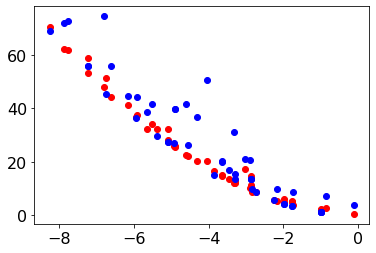

In [22]:
M_test = 50
X_test = chains(log_proposal,
                2,
                n_samples=25,
                epsilon=0.2,
                pr_args=(V, ),
                dim=2,
                n_burn=300)
f_test = func(X_test)
x_forward = asub.forward(X_test)[0]
optimal_profile = np.array([profile(x_forward[i, :], asub, func) for i in range(M_test)])
print(g.shape, x_forward.shape)
plt.scatter(x_forward, optimal_profile, c='r')
plt.scatter(x_forward, f_test, c='b')
plt.show()

Optimization restart 1/5, f = 112.45452480984078
Optimization restart 2/5, f = 112.45452480977474
Optimization restart 3/5, f = 112.4545248098234
Optimization restart 4/5, f = 112.45452480972568
Optimization restart 5/5, f = 112.45452481012403
Optimization restart 1/5, f = 177.73089212839807
Optimization restart 2/5, f = 177.73089217650812
Optimization restart 3/5, f = 177.7308921283404
Optimization restart 4/5, f = 177.73089212837317
Optimization restart 5/5, f = 177.73089212834088


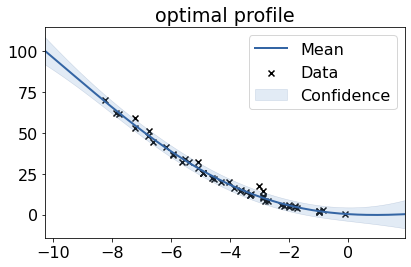

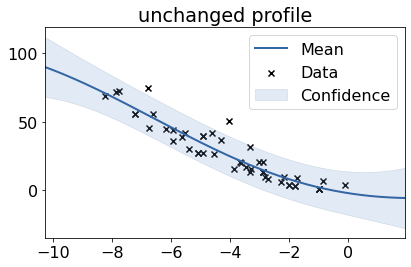

Relative Root Mean Square Error for optimal profile 144.481%
Relative Root Mean Square Error for unchanged profile 49.401%


In [23]:
gp_g = GPy.models.GPRegression(x_forward, optimal_profile.reshape(-1, 1))
gp_f = GPy.models.GPRegression(x_forward, f_test.reshape(-1, 1))

gp_g.constrain_positive('')
gp_g.optimize_restarts(5)

gp_f.constrain_positive('')
gp_f.optimize_restarts(5)

gp_g.plot(title="optimal profile")
gp_f.plot(title="unchanged profile")
plt.show()

y_g = gp_g.predict(x_forward)[0]
y_f = gp_f.predict(x_forward)[0]

def RRMSE(test, true):
    return np.sqrt(np.sum((test.reshape(-1) - true.reshape(-1))**2) )#/ np.sum((true - true.mean())**2))

print("Relative Root Mean Square Error for optimal profile {:.3f}%".format(RRMSE(y_g, g)))
print("Relative Root Mean Square Error for unchanged profile {:.3f}%".format(RRMSE(y_f, f_test)))

### Remarks

Try changing the potential V i.e. the probability density function $p(y,z)$ in order to study different input distributions.